In [17]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, EfficientNetB7
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import numpy as np
import pandas as pd 
import os
import pickle
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")

In [18]:
train_path = "./train"
test_path = "./test"

In [19]:
def process_data(img_dims, batch_size):
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_gen = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
  )

  test_gen = test_datagen.flow_from_directory(
      directory=test_path,
      target_size=(img_dims, img_dims),
      batch_size=batch_size,
      class_mode='binary',
      shuffle=True
  )

  return (train_gen, test_gen)

In [20]:
img_dims = 160
epochs=10
batch_size=16

train_gen, test_gen = process_data(img_dims, batch_size)

Found 12134 images belonging to 2 classes.
Found 2615 images belonging to 2 classes.


In [22]:
xception = Xception(input_shape=(160, 160, 3), weights='imagenet', include_top=False)

for layer in xception.layers:
    layer.trainable = False

regularizer = L2(l2=0.001)

x = Flatten()(xception.output)
prediction = Dense(1024, activation='relu', kernel_regularizer=regularizer)(x)
prediction = Dense(512, activation='relu', kernel_regularizer=regularizer)(prediction)
prediction = Dense(256, activation='relu', kernel_regularizer=regularizer)(prediction)
prediction = Dense(32, activation='relu', kernel_regularizer=regularizer)(prediction)
prediction = Dense(1, activation='sigmoid')(prediction)

model1 = Model(inputs=xception.input, outputs=prediction)

model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [23]:
model1.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [25]:
hist = model1.fit(
  train_gen,
  batch_size=16,
  epochs=10, validation_data=test_gen,
  verbose=1
)

Epoch 1/10
759/759 [==============================] - 745s 982ms/step - loss: 0.9362 - accuracy: 0.8228 - val_loss: 0.6482 - val_accuracy: 0.8337
Epoch 2/10
759/759 [==============================] - 691s 910ms/step - loss: 0.5439 - accuracy: 0.8553 - val_loss: 0.4997 - val_accuracy: 0.8554
Epoch 3/10
759/759 [==============================] - 650s 856ms/step - loss: 0.4326 - accuracy: 0.8770 - val_loss: 0.4522 - val_accuracy: 0.8589
Epoch 4/10
759/759 [==============================] - 640s 843ms/step - loss: 0.3781 - accuracy: 0.8871 - val_loss: 0.4130 - val_accuracy: 0.8711
Epoch 5/10
759/759 [==============================] - 816s 1s/step - loss: 0.3431 - accuracy: 0.8968 - val_loss: 0.3818 - val_accuracy: 0.8837
Epoch 6/10
759/759 [==============================] - 669s 882ms/step - loss: 0.3135 - accuracy: 0.9071 - val_loss: 0.3707 - val_accuracy: 0.8784
Epoch 7/10
759/759 [==============================] - 634s 835ms/step - loss: 0.3022 - accuracy: 0.9111 - val_loss: 0.3766 - va

In [26]:
model1.save("xception.h5")

In [29]:
with open('xception_hist.pkl', 'wb') as f:
  pickle.dump(hist.history, f)

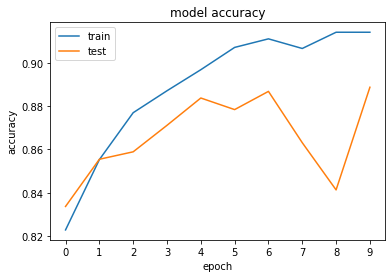

In [32]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

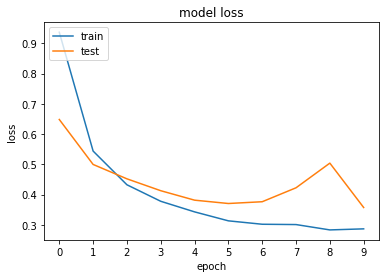

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.legend(['train', 'test'], loc='upper left')
plt.show()